## Журнал "Петрология": анализ публикативной активности 2/3

<hr style="border:solid orange 1px">

### Оценка самоцитирования и различных импакт-факторов

---

Основные задачи данного анализа оценить:
- самоцитируемость публикаций;
- рассчитать различные импакт-факторы и их вариацию;
- оценить риски и проблемы

В качестве исходных данных используются свободные сведения о цитировании публикаций в системе `Scopus`.  Данные представляют собой таблицу с данными по цитируемости статей одного выпуска (года) по годам. Исходные данные достаточно простые, верные и не требует специальной предобработки.

Данные предоставлены за период `2014-2020` год. Базы актуальны на `сентябрь 2020 года`. Хотя, конечно, ясно, что данные по 2019 и 2020 году пока неполные.

---

In [1]:
# Загрузка необходимых модулей:
import pandas as pd

# Подгрузим библиотеки для построения графиков:
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

# Модуль для игнорирования ошибок и предупреждений:
import warnings
warnings.simplefilter('ignore')

# Изображение картинок в хорошем качестве:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Загрузка и обработка исходных данных с сайта `Scopus`

In [2]:
# Загрузка датасета и работа с его подготовкой:
# data = pd.read_csv("/kaggle/input/petrology/scopus0820.csv")
data = pd.read_excel("data/petrology_scopus_0920_1.xlsx")
                   
# Корректировка типа данных:
data['self_citation'] = data['self_citation'].astype('bool')

In [3]:
data.head()

,publ_year,self_citation,papers,citaion_year,cites
0,2014,True,33,2014,6
1,2014,True,33,2015,22
2,2014,True,33,2016,29
3,2014,True,33,2017,43
4,2014,True,33,2018,37


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   publ_year      98 non-null     int64
 1   self_citation  98 non-null     bool 
 2   papers         98 non-null     int64
 3   citaion_year   98 non-null     int64
 4   cites          98 non-null     int64
dtypes: bool(1), int64(4)
memory usage: 3.3 KB


In [5]:
# Рассчитаем долю самоцитирования:
self_citation_proportion = (data
      .query('self_citation == 1')   
      .groupby(['publ_year'])
      .agg({'cites' : 'sum'})
      .sort_values(by = 'publ_year', ascending = False)
      .reset_index()
     ).merge(
    (data
      .query('self_citation == 0')   
      .groupby(['publ_year'])
      .agg({'cites' : 'sum'})
      .sort_values(by = 'publ_year', ascending = False)
      .reset_index()
     ), left_on = 'publ_year', right_on = 'publ_year', how = 'left'
     )

self_citation_proportion.columns = ('publ_year', 'cites_with_selfcitations', 'cites_wo_selfcitations')
self_citation_proportion['proportions'] = (self_citation_proportion['cites_with_selfcitations'] \
                                           - self_citation_proportion['cites_wo_selfcitations']) \
                                           / self_citation_proportion['cites_with_selfcitations']

self_citation_proportion.sort_values(by = 'publ_year', ascending = True).style.format({
            'proportions': "{:.0%}"
})

,publ_year,cites_with_selfcitations,cites_wo_selfcitations,proportions
6,2014,218,109,50%
5,2015,144,79,45%
4,2016,174,95,45%
3,2017,127,75,41%
2,2018,79,30,62%
1,2019,22,8,64%
0,2020,3,1,67%


In [6]:
# Функция, которая показывает значения на бар-диаграммах:
def show_values_on_bars(axs, h_v="v", space=0.4, space_y=0, rounded = 0):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + space_y
                value = (p.get_height()).round(rounded)
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() -0.2
                value = (p.get_width()).round(rounded)
                ax.text(_x, _y, value, ha="left", fontsize=8)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

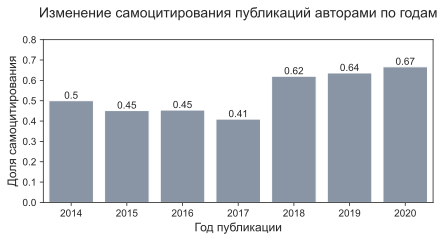

In [7]:
# Визуализируем данные:
plt.figure(figsize = (7,3))  

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.barplot(x="publ_year", 
                y='proportions', 
                data=self_citation_proportion,
                color="#8595A8",
               )

# Название, подписи осей:
plt.title("Изменение самоцитирования публикаций авторами по годам", fontsize=14, y=1.1)
g.set_xlabel('Год публикации', fontsize=12)
g.set_ylabel('Доля самоцитирования', fontsize=12)

# Масштаб осей:
g.set(ylim=(0, 0.8)) 

# Вызов функции для подписи значений на барах:
show_values_on_bars(g, "v", 0, 0.01, 2)

# Сохранение рисунка:
plt.savefig("images/selfcitation_proportion.svg", dpi=300, transparent=True, bbox_inches = "tight")

Конечно, `2020` год следует отбросить. Однако данные показывают общую тенденцию увеличения доли самоцитирования в последние годы - увеличение с `40-50%` ссылок до `60%`. Самоцитирование - цитаты отдельных авторов в других журналах на свои статьи.

---

Далее создадим функцию, которая производит расчет импакт-фактора - `IF` по версии системы `Web Of Science`, но на основе статистических данных `Scopus`. <a class="anchor" id="if_year"></a>

In [8]:
# Функция, которая производит расчет импакт фактора - IF
def if_year(year, self_citation = True):
    if_year = year
    paper_years = ((if_year - 1),(if_year - 2))
    
    if_calc = (data
        .query('publ_year in @paper_years and self_citation == True')
        .query('citaion_year == @if_year')
        .groupby(['publ_year'])
          .agg({'papers' : 'mean', 'cites' : 'sum'})
          .sort_values(by = 'publ_year', ascending = False)
          .reset_index() 
    )
    
    if_year = if_calc.cites.sum() / if_calc.papers.sum()
    return if_year

In [9]:
# Проведем расчет импакт-фактора за 2016-2020 годы:
if_index = []

for i in range(2016, 2021):
    if_ = if_year(i)
    if_index.append([i, if_]) 

if_table = (pd.DataFrame(if_index, columns = ['year', 'IF']))
if_table.style.format({'IF': "{:.3f}"})

,year,IF
0,2016,0.852
1,2017,1.068
2,2018,1.290
3,2019,1.385
4,2020,0.754


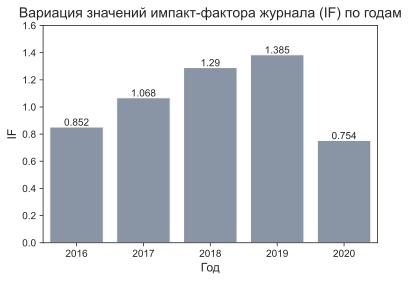

In [10]:
# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.barplot(x="year", 
                y='IF', 
                data=if_table,
                color="#8595A8",
               )

# Название, подписи осей:
plt.title("Вариация значений импакт-фактора журнала (IF) по годам", fontsize=14, y=1.01)
g.set_xlabel('Год', fontsize=12)
g.set_ylabel('IF', fontsize=12)

# Масштаб осей:
g.set(ylim=(0, 1.6)) 

# Вызов функции для подписи значений на барах:
show_values_on_bars(g, "v", 0, 0.01, 3)

# Сохранение рисунка:
plt.savefig("images/IF.svg", dpi=300, transparent=True, bbox_inches = "tight")

Данные показывают, что `IF` увеличивается за последние несколько лет, что является положительным фактором. Может немного настораживать низкое значение импакт-фактора в `2020 год`у. Несмотря на то, что год еще не закрыт статистически, многие профильные журналы уже публикуют статьи 2021 года... Поэтому, есть основание полагать, что `IF2020 резко просядет`. Все это из-за плохой цитируемости статей 2019 года в 2020 году.

---

Далее проведем расчет функции, которая считает `CiteScore` - специальный рейтинг от `Scopus`, который считает количество ссылок за 4 года, на статьи этих годов. <a class="anchor" id="CS_year"></a>

In [11]:
# Функция, которая производит расчет CiteScore:
def CS_year(year, self_citation = True):
    CS_year = year
    paper_years = (CS_year,(CS_year - 1),(CS_year - 2),(CS_year - 3))
    cites_years = (CS_year,(CS_year - 1),(CS_year - 2),(CS_year - 3))
    
    CS_calc = (data
        .query('publ_year in @paper_years and self_citation == @self_citation')
        .query('citaion_year in @cites_years')
        .groupby(['publ_year'])
          .agg({'papers' : 'mean', 'cites' : 'sum'})
          .sort_values(by = 'publ_year', ascending = False)
          .reset_index() 
        )
    CS_calc = CS_calc.cites.sum() / CS_calc.papers.sum()
    
    return CS_calc

In [12]:
# Проведем расчет CiteScore за 2017-2020 годы:
CS_index = []

for i in range(2017, 2021):
    cs_ = CS_year(i)
    CS_index.append([i, cs_]) 

CS_table = (pd.DataFrame(CS_index, columns = ['year', 'CiteScore']))
CS_table.style.format({'CiteScore': "{:.1f}"})

,year,CiteScore
0,2017,1.7
1,2018,1.9
2,2019,2.1
3,2020,1.9


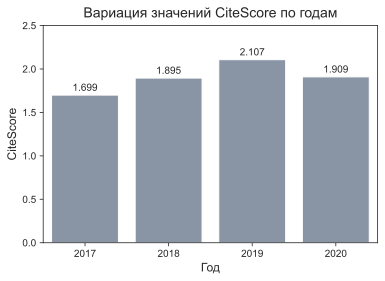

In [13]:
# Сетка графика:
plt.grid(b=True, which='major', color='black', linewidth=0.05)
plt.grid(b=True, which='minor', color='black', linewidth=0.05)

# Сам график:
g = sns.barplot(x="year", 
                y='CiteScore', 
                data=CS_table,
                color="#8595A8",
               )

# Название, подписи осей:
plt.title("Вариация значений CiteScore по годам", fontsize=14, y=1.01)
g.set_xlabel('Год', fontsize=12)
g.set_ylabel('CiteScore', fontsize=12)

# Вызов функции для подписи значений на барах:
show_values_on_bars(g, "v", 0, 0.05, 3)

# Масштаб осей:
g.set(ylim=(0, 2.5)) 

# Сохранение рисунка:
plt.savefig("images/CiteScore.svg", dpi=300, transparent=True, bbox_inches = "tight")

В целом, выводы такие же как и по `IF`, за исключением менее выраженного провала в `2020` году. Результаты расчета импакт-факторов позволяют предположить, что в `2020` году очень возможно `снижение` значений этих индексов.

---

Далее посмотрим на количество цитат в зависимость от времени жизни статьи.

In [14]:
# Подсчитаем возраст статьи для цитат:
data['lifetime'] =  data['citaion_year'] - data['publ_year']
data.query('lifetime >= 0 and self_citation == True').head()

,publ_year,self_citation,papers,citaion_year,cites,lifetime
0,2014,True,33,2014,6,0
1,2014,True,33,2015,22,1
2,2014,True,33,2016,29,2
3,2014,True,33,2017,43,3
4,2014,True,33,2018,37,4


In [15]:
# Проведем когортный анализ, где когорта - год публикации:
cohorts = (data
           .query('lifetime >= 0 and self_citation == True')
           .groupby(['publ_year','lifetime']).agg({'cites':'sum'}).reset_index()
          )

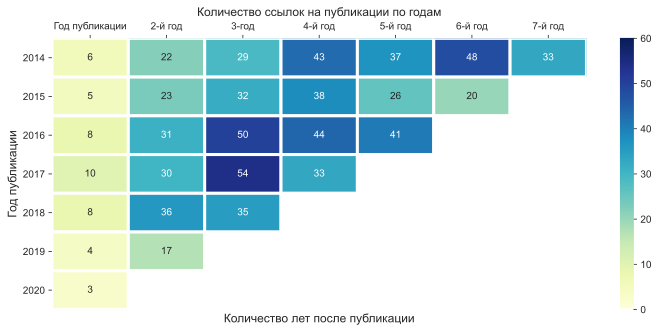

In [16]:
# Визуализируем данны:
plt.figure(figsize = (12,5)) 

cohorts_pivot = cohorts.pivot_table(index='publ_year',columns='lifetime',values='cites',aggfunc='sum')

# Сам график:
g = sns.heatmap(cohorts_pivot, annot=True, linewidths=3, linecolor='white', cmap="YlGnBu", vmin=0, vmax=60,)

# Основной стиль графика:
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# Ось Х:
g.xaxis.tick_top()
xticks_labels = ['Год публикации', '2-й год', '3-год', '4-й год', '5-й год', '6-й год', '7-й год']
plt.xticks(np.arange(7) + .5, labels=xticks_labels)

# Название, подписи осей:
plt.title('Количество ссылок на публикации по годам', loc='center')
g.set_xlabel('Количество лет после публикации', fontsize=12)
g.set_ylabel('Год публикации', fontsize=12)

# Параметры осей:
plt.yticks(rotation=0)
plt.xticks()

# Сохранение рисунка:
plt.savefig("images/cohorts.svg", dpi=300, transparent=True, bbox_inches = "tight")

Данные показывают, что:
- первые цитаты появляются в год опубликования статей;
- во второй год жизни статьи, на нее начинают более активно ссылаться, при этом к третьему и/или четвертому году количество ссылок может увеличиваться;
- данных не так много, но они позволяют предположить, что в целом, на пятый - седьмой годы жизни статьи количество ссылок будет неминуемо снижаться, по всей видимости, теряется актуальность публикаций. 

<hr style="border:solid orange 1px">

### Промежуточные выводы

---

Анализ данных показал, что:
- можно отметить общую тенденцию увеличения доли самоцитирования в последние годы - увеличение с `40-50%` ссылок до `60%`;
- `IF` увеличивается за последние несколько лет, что является положительным фактором;
- следует обратить внимание на то, что в `2020 году` значение `IF` относительно низкое, несмотря на неполноту данных, поэтому есть основание полагать, что `IF2020 резко просядет`;
- анализ количества цитат в зависимости от времени жизни статьи показал, что:
    - первые цитаты появляются в год опубликования статей;
    - во второй год жизни статьи, на нее начинают более активно ссылаться, при этом к третьему и/или четвертому году количество ссылок может увеличиваться;
    - данных не так много, но они позволяют предположить, что в целом, на пятый - седьмой годы жизни статьи количество ссылок будет неминуемо снижаться, по всей видимости, теряется актуальность публикаций.

---

Для удобства анализа данных были созданы несколько функций, которые позволяют:
- [**if_year(year, self_citation)**](#if_year) - функция, которая производит расчет импакт-фактора - `IF` по версии системы `Web Of Science`;
- [**CS_year(year, self_citation)**](#CS_year) - функция, которая считает `CiteScore` - специальный рейтинг от `Scopus`, который считает количество ссылок за 4 года, на статьи этих годов. 
